# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [1]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables import encode_tags


## Data Importing

In [3]:
## Data Importing load one file first to see what type of data you're dealing with and what attributes it has 
# loop over all files and put them into a dataframe 

In [2]:
# 1.1 locate files
data_dir = "../data"
files = os.listdir(data_dir)
json_files = [f for f in files if f.endswith(".json")]

In [ ]:
with open(os.path.join(data_dir, json_files[0]), "r") as f:
    sample = json.load(f)

first_sale = sample["data"]["results"][0]

print("Keys in first sale record:", list(first_sale.keys()))
print("Keys in description:", list(first_sale.get("description", {}).keys()))
print("Keys in flags:", list(first_sale.get("flags", {}).keys()))
print("Sample tags list:", first_sale.get("tags", [])[:5])
pprint(first_sale)

Keys in first sale record: ['primary_photo', 'last_update_date', 'source', 'tags', 'permalink', 'status', 'list_date', 'open_houses', 'description', 'branding', 'list_price', 'lead_attributes', 'property_id', 'photos', 'flags', 'community', 'products', 'virtual_tours', 'other_listings', 'listing_id', 'price_reduced_amount', 'location', 'matterport']
Keys in description: ['year_built', 'baths_3qtr', 'sold_date', 'sold_price', 'baths_full', 'name', 'baths_half', 'lot_sqft', 'sqft', 'baths', 'sub_type', 'baths_1qtr', 'garage', 'stories', 'beds', 'type']
Keys in flags: ['is_new_construction', 'is_for_rent', 'is_subdivision', 'is_contingent', 'is_price_reduced', 'is_pending', 'is_foreclosure', 'is_plan', 'is_coming_soon', 'is_new_listing']
Sample tags list: ['central_air', 'dishwasher', 'fireplace', 'forced_air', 'hardwood_floors']
{'branding': [{'name': 'Howard Hanna - Colonial Park',
               'photo': None,
               'type': 'Office'}],
 'community': None,
 'description': {'bat

In [40]:

first_sale = sample["data"]["results"][0]["tags"] 
pprint(first_sale)

['central_air',
 'dishwasher',
 'fireplace',
 'forced_air',
 'hardwood_floors',
 'washer_dryer',
 'basement',
 'single_story',
 'garage_1_or_more',
 'garage_2_or_more',
 'big_yard',
 'vaulted_ceiling',
 'open_floor_plan',
 'floor_plan',
 'corner_lot',
 'big_lot',
 'ensuite']


In [7]:
all_sales = []
for fn in json_files:
    path = os.path.join(data_dir, fn)
    try:
        with open(path, "r") as f:
            data = json.load(f)
        all_sales.extend(data["data"]["results"])
    except json.JSONDecodeError:
        print(f"  • skipping bad file {fn}")


In [8]:
df = pd.json_normalize(all_sales)
print(f"Loaded {len(df)} records with {df.shape[1]} columns")

Loaded 8159 records with 67 columns


## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 67 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       8125 non-null   object 
 1   tags                                   7638 non-null   object 
 2   permalink                              8159 non-null   object 
 3   status                                 8159 non-null   object 
 4   list_date                              7752 non-null   object 
 5   open_houses                            0 non-null      object 
 6   branding                               8159 non-null   object 
 7   list_price                             7721 non-null   float64
 8   property_id                            8159 non-null   object 
 9   photos                                 7403 non-null   object 
 10  community                              0 non-null      float64
 11  virt

In [12]:
df.describe()


,list_price,community,price_reduced_amount,description.year_built,description.baths_3qtr,description.sold_price,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,...,description.stories,description.beds,location.address.coordinate.lon,location.address.coordinate.lat,primary_photo,source,products,other_listings,location.address.coordinate,location.county
count,7.721000e+03,0.0,2.484000e+03,7316.000000,566.000000,6.716000e+03,7311.000000,2281.000000,6.991000e+03,7323.000000,...,6260.000000,7504.000000,7909.000000,7909.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,4.341582e+05,NaN,2.442704e+04,1968.916074,1.247350,4.126050e+05,1.887430,1.105655,2.510949e+05,1933.848559,...,1.567732,3.208289,-92.206522,39.009689,NaN,NaN,NaN,NaN,NaN,NaN
std,5.514925e+05,NaN,7.162396e+04,35.096914,0.463482,6.994308e+05,0.862214,0.413340,5.823820e+06,1339.039206,...,0.730969,1.282732,15.888886,4.374553,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,1.000000e+02,1828.000000,1.000000,3.080000e+02,1.000000,1.000000,0.000000e+00,120.000000,...,1.000000,0.000000,-157.810583,21.277707,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.090000e+05,NaN,6.000000e+03,1950.000000,1.000000,1.910000e+05,1.000000,1.000000,4.953000e+03,1258.000000,...,1.000000,3.000000,-104.971611,35.688084,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.250000e+05,NaN,1.010000e+04,1975.000000,1.000000,3.140000e+05,2.000000,1.000000,7.841000e+03,1635.000000,...,1.000000,3.000000,-89.333131,39.698210,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.999000e+05,NaN,2.000000e+04,1997.000000,1.000000,4.700000e+05,2.000000,1.000000,1.263200e+04,2264.000000,...,2.000000,4.000000,-78.617690,41.832266,NaN,NaN,NaN,NaN,NaN,NaN
max,1.250000e+07,NaN,2.015999e+06,2024.000000,3.000000,2.706500e+07,8.000000,5.000000,1.676624e+08,32106.000000,...,10.000000,12.000000,-71.006343,58.396178,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Find any remaining list/dict cells
print("\nNested columns:")
for c in df.columns:
    v = df[c].dropna()
    if not v.empty and isinstance(v.iloc[0], (list, dict)):
        print(" ", c)


Nested columns:
  tags
  branding
  photos
  virtual_tours
  source.agents
  other_listings.rdc
  community.advertisers


In [15]:
# 3.1 simplify column names (dots → underscores; shorten coords)
df.columns = (
    df.columns
      .str.replace(r"\.", "_", regex=True)
      .str.replace("location_address_coordinate", "coord")
)

In [16]:
# 3.2 drop rows without a sale price
df = df.dropna(subset=["description_sold_price"])
print("After dropping missing target:", len(df))

After dropping missing target: 6716


In [17]:
# 3.3 impute key numerics in one go
fill_values = {
    "description_garage": 0,
    "description_beds": df["description_beds"].median(),
    "description_baths_full": 0,
    "description_sqft": df["description_sqft"].median(),
    "description_lot_sqft": df["description_lot_sqft"].median(),
}
df = df.fillna(value=fill_values)


In [18]:
# 3.4 convert dates to datetime
for date_col in ["list_date", "last_update_date", "description_sold_date"]:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")


In [19]:
# 3.5 drop leak/prone or useless cols
to_drop = [
    "open_houses", "community", "virtual_tours",
    "photos", "branding", "lead_attributes",
    "products", "flags", "source", "list_price"
]
df = df.drop(columns=[c for c in to_drop if c in df.columns])

In [20]:
# 3.6 drop rows missing location
df = df.dropna(subset=["coord_lon", "coord_lat"])
print("Shape after cleaning:", df.shape)

Shape after cleaning: (6537, 59)


### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [ ]:
# OHE categorical variables/ tags here
# tags will have to be done manually

In [28]:
# Number of tag dummies
n_tags   = len([c for c in df.columns if c.startswith("tag_")])

# If you OHE cities and states (before target‐encoding), for example:
n_cities = df["location_address_city"].nunique()
n_states = df["location_address_state"].nunique()

print(f"Dummy columns → tags: {n_tags}, cities: {n_cities}, states: {n_states}, total: {n_tags + n_cities + n_states}")


Dummy columns → tags: 92, cities: 81, states: 35, total: 208


In [ ]:
# New tag encoding via your helper function
from functions_variables import encode_tags

# 4.1 Get a dict of 0/1 flags for every row
tag_dicts = df["tags"].apply(lambda lst: encode_tags(lst) if isinstance(lst, list) else {})

# 4.2 Build a DataFrame of those flags
tags_df = (
    pd.DataFrame(tag_dicts.tolist(), index=df.index)
      .fillna(0)
      .astype(int)
)

# 4.3 Join back and drop the list column
df = pd.concat([df, tags_df], axis=1).drop(columns=["tags"])
print("After encode_tags, shape:", df.shape)

# 4.4 Prune any tag that appears in <1% of homes
tag_cols = [c for c in tags_df.columns]  # these are all your tag_* columns
threshold = 0.01 * len(df)
rare = [c for c in tag_cols if df[c].sum() < threshold]
df = df.drop(columns=rare)
print(f"Dropped {len(rare)} rare tags; {len(tag_cols)-len(rare)} remain.")



### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [27]:
# perform train test split here
# do something with state and city

from sklearn.model_selection import train_test_split

# 1. Split into X / y
X = df.drop(columns="description_sold_price")
y = df["description_sold_price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Target-encode city on TRAIN only
city_means = (
    pd.concat([X_train, y_train], axis=1)
      .groupby("location_address_city")["description_sold_price"]
      .mean()
)
X_train["city_price"] = X_train["location_address_city"].map(city_means)
X_test ["city_price"] = X_test ["location_address_city"].map(city_means)

# 3. Target-encode state on TRAIN only
state_means = (
    pd.concat([X_train, y_train], axis=1)
      .groupby("location_address_state")["description_sold_price"]
      .mean()
)
X_train["state_price"] = X_train["location_address_state"].map(state_means)
X_test ["state_price"] = X_test ["location_address_state"].map(state_means)

# 4. Fill any missing (unknown city or state) with the overall mean
global_mean = y_train.mean()
X_train["city_price"]  = X_train["city_price"].fillna(global_mean)
X_train["state_price"] = X_train["state_price"].fillna(global_mean)
X_test ["city_price"]  = X_test ["city_price"].fillna(global_mean)
X_test ["state_price"] = X_test ["state_price"].fillna(global_mean)

# 5. Drop the raw location columns
X_train = X_train.drop(columns=["location_address_city", "location_address_state"])
X_test  = X_test .drop(columns=["location_address_city", "location_address_state"])

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)


X_train shape: (5229, 149)
X_test  shape: (1308, 149)


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_13747/3888368439.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train["city_price"] = X_train["location_address_city"].map(city_means)
/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_13747/3888368439.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test ["city_price"] = X_test ["location_address_city"].map(city_means)
/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_13747/3888368439.py:28: PerformanceWarning: DataFrame is highly fragmen

## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [ ]:
# import, join and preprocess new data here

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

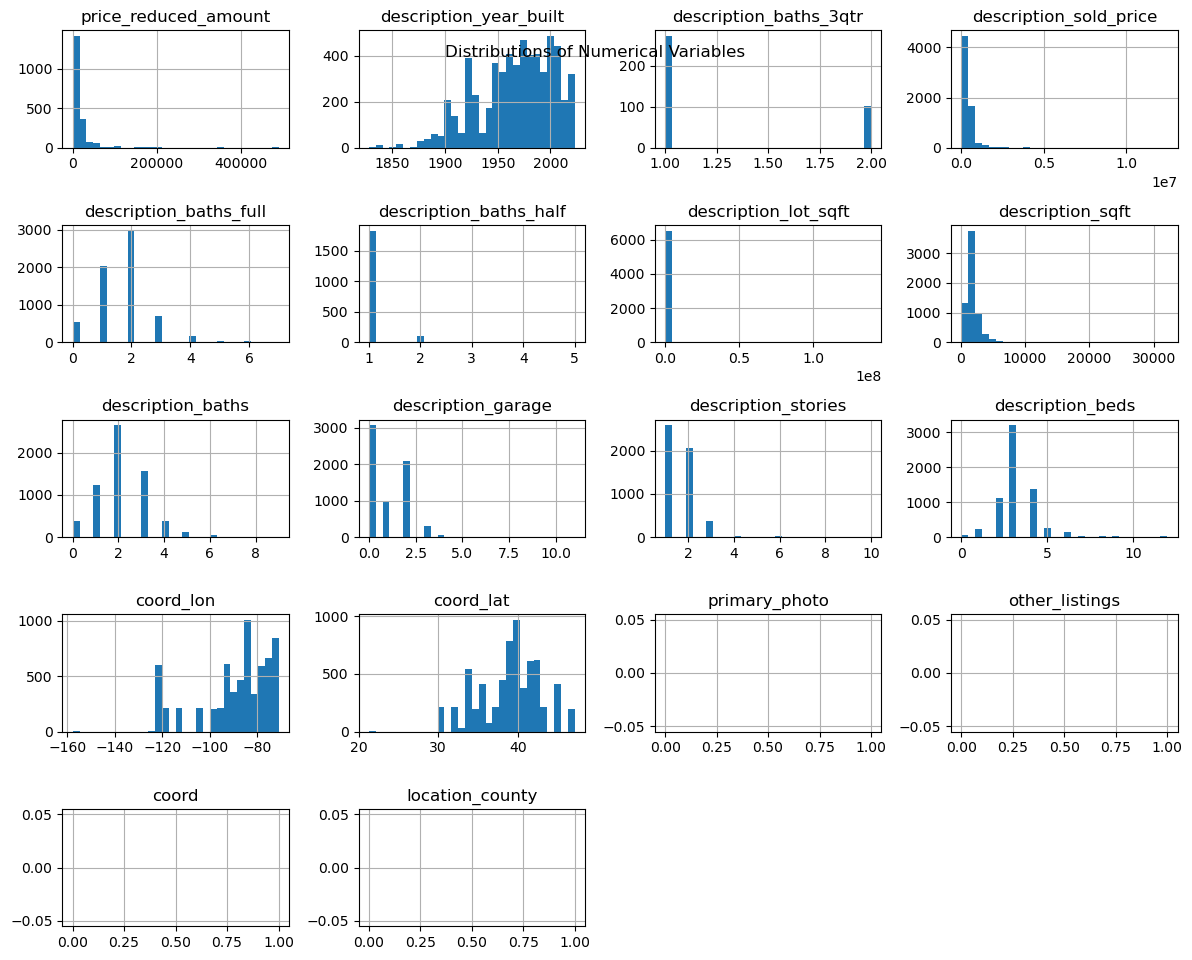

In [42]:
# perform EDA here

import matplotlib.pyplot as plt
import numpy as np


# 1.1 Grab all numeric columns (including our target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 1.2 Plot histograms
df[num_cols].hist(bins=30, figsize=(12, 10))
plt.suptitle("Distributions of Numerical Variables", y=0.92)
plt.tight_layout()
plt.show()


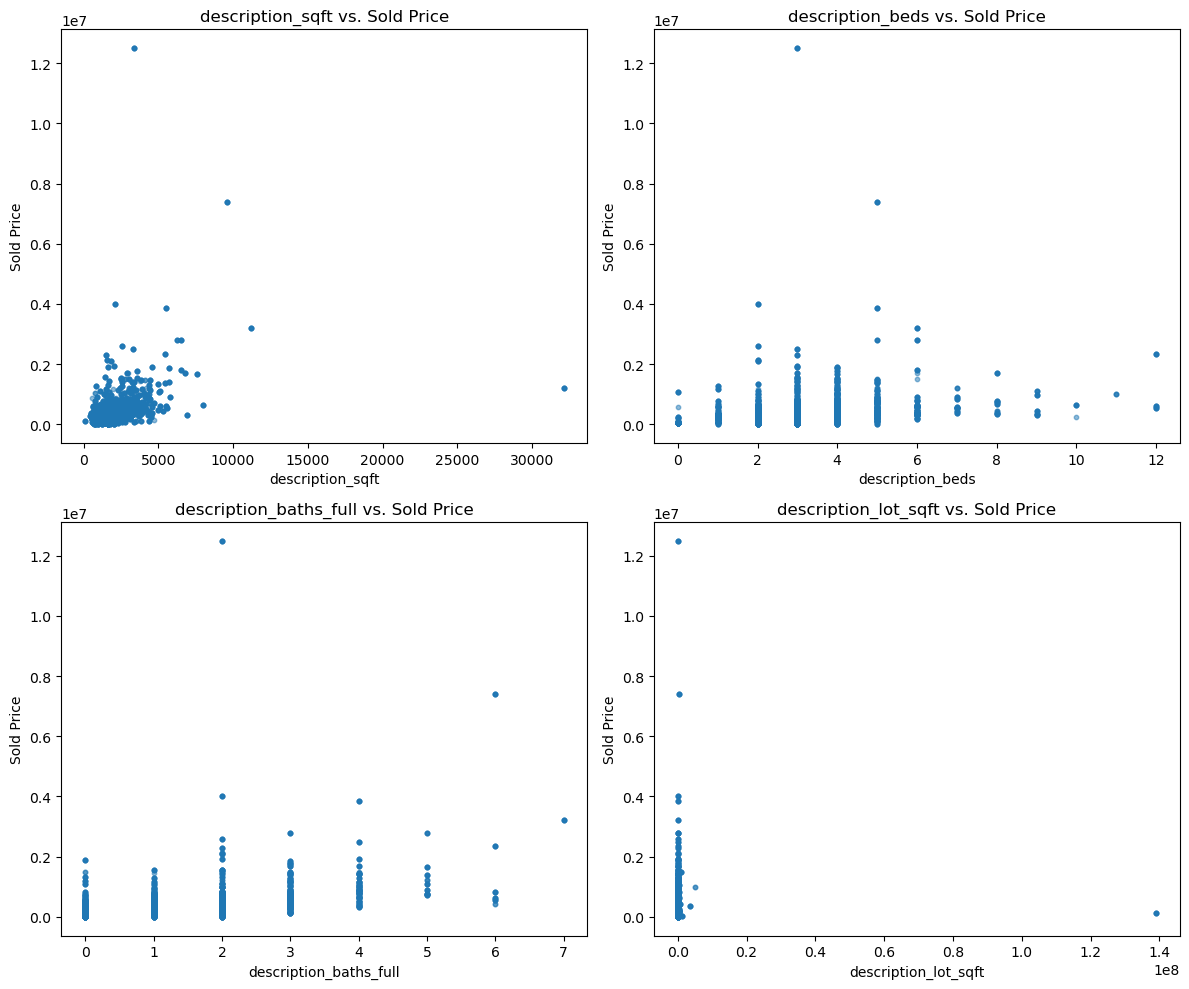

In [44]:
# Choose only columns that actually exist in df
features = [
    "description_sqft",
    "description_beds",
    "description_baths_full",
    "description_lot_sqft",
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    ax.scatter(df[feat], df["description_sold_price"], alpha=0.5, s=10)
    ax.set_xlabel(feat)
    ax.set_ylabel("Sold Price")
    ax.set_title(f"{feat} vs. Sold Price")

plt.tight_layout()
plt.show()



In [45]:
# 3.1 Compute correlation matrix (absolute values)
corr = df[num_cols].corr().abs()

# 3.2 If too many variables for a heatmap, list top pairs
#    Flatten matrix, drop self-correlations, sort
pairs = (
    corr.unstack()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"level_0":"var1","level_1":"var2",0:"corr"})
)
top_pairs = pairs[pairs["var1"] != pairs["var2"]].drop_duplicates(subset=["corr"]).head(10)

print("Top 10 feature pairs by absolute correlation:")
print(top_pairs.to_string(index=False))


Top 10 feature pairs by absolute correlation:
                  var1                   var2     corr
     description_baths description_baths_full 0.842277
  price_reduced_amount description_sold_price 0.810495
     description_baths       description_sqft 0.687978
description_baths_full       description_beds 0.528204
     description_baths       description_beds 0.526062
     description_baths description_baths_half 0.480625
      description_beds       description_sqft 0.455044
description_baths_full       description_sqft 0.419462
   description_stories       description_beds 0.412384
description_sold_price      description_baths 0.403805


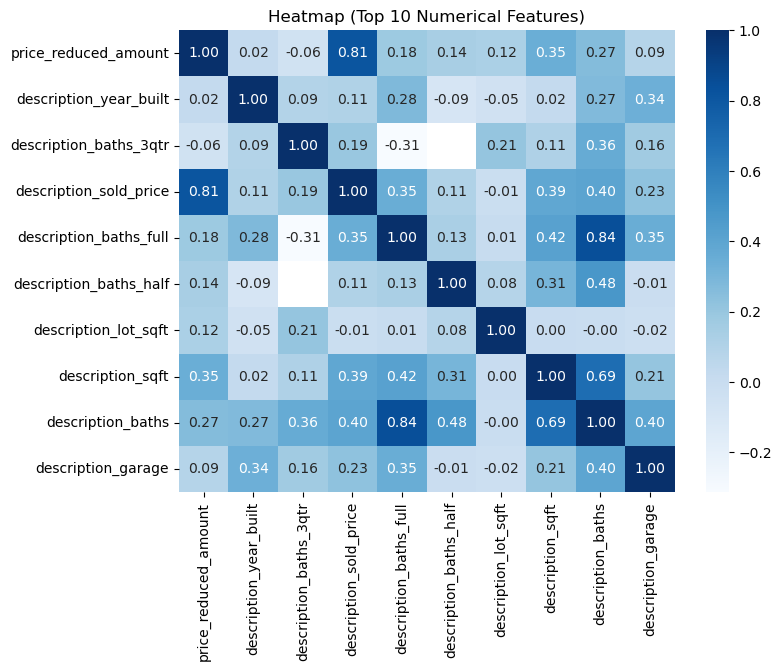

In [46]:
import seaborn as sns

top_vars = num_cols[:10]  # or pick your most important ones
plt.figure(figsize=(8, 6))
sns.heatmap(df[top_vars].corr(), annot=True, fmt=".2f", cmap="Blues")
plt.title("Heatmap (Top 10 Numerical Features)")
plt.show()


In [47]:
# 4.1 Example: are beds + baths_full + baths_half redundant?
redundant = ["description_beds", "description_baths_full", "description_baths"]
print(df[redundant].corr())


                        description_beds  description_baths_full  \
description_beds                1.000000                0.528204   
description_baths_full          0.528204                1.000000   
description_baths               0.526062                0.842277   

                        description_baths  
description_beds                 0.526062  
description_baths_full           0.842277  
description_baths                1.000000  


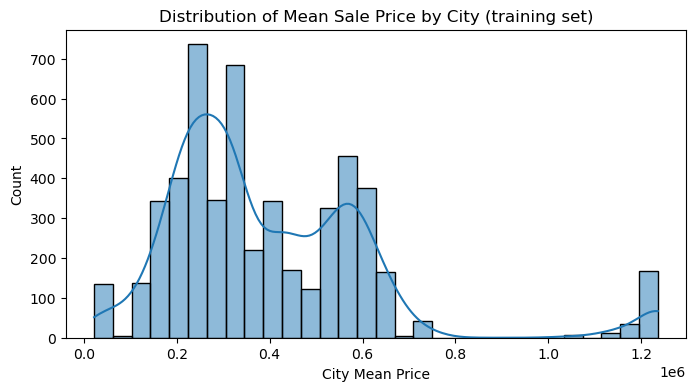

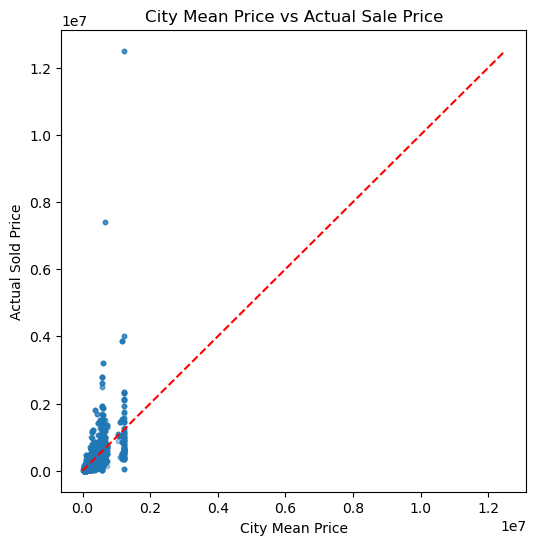

In [48]:
# plot distribution of city_price
plt.figure(figsize=(8,4))
sns.histplot(X_train["city_price"], bins=30, kde=True)
plt.title("Distribution of Mean Sale Price by City (training set)")
plt.xlabel("City Mean Price"); plt.ylabel("Count")
plt.show()

# scatter city_price vs actual price
plt.figure(figsize=(6,6))
plt.scatter(X_train["city_price"], y_train, alpha=0.4, s=10)
plt.plot([0, y_train.max()], [0, y_train.max()], 'r--')
plt.title("City Mean Price vs Actual Sale Price")
plt.xlabel("City Mean Price"); plt.ylabel("Actual Sold Price")
plt.show()


## Changes after EDA

In [50]:
# 1. Compute the full-dataset mean price per city & state
city_means_full = (
    df.groupby("location_address_city")["description_sold_price"]
      .mean()
      .rename("city_price")
)
state_means_full = (
    df.groupby("location_address_state")["description_sold_price"]
      .mean()
      .rename("state_price")
)

# 2. Join them onto df
df = (
    df
      .join(city_means_full,  on="location_address_city")
      .join(state_means_full, on="location_address_state")
)

# 3. (Optional) Fill any missing if some city/state had no sales
global_mean = df["description_sold_price"].mean()
df["city_price"].fillna(global_mean, inplace=True)
df["state_price"].fillna(global_mean, inplace=True)

# Quick check
df[["location_address_city","city_price","location_address_state","state_price"]].head()


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_13747/3667256054.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["city_price"].fillna(global_mean, inplace=True)
/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_13747/3667256054.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

,location_address_city,city_price,location_address_state,state_price
0,Harrisburg,238074.285714,Pennsylvania,238074.285714
1,Harrisburg,238074.285714,Pennsylvania,238074.285714
2,Harrisburg,238074.285714,Pennsylvania,238074.285714
3,Harrisburg,238074.285714,Pennsylvania,238074.285714
4,Harrisburg,238074.285714,Pennsylvania,238074.285714


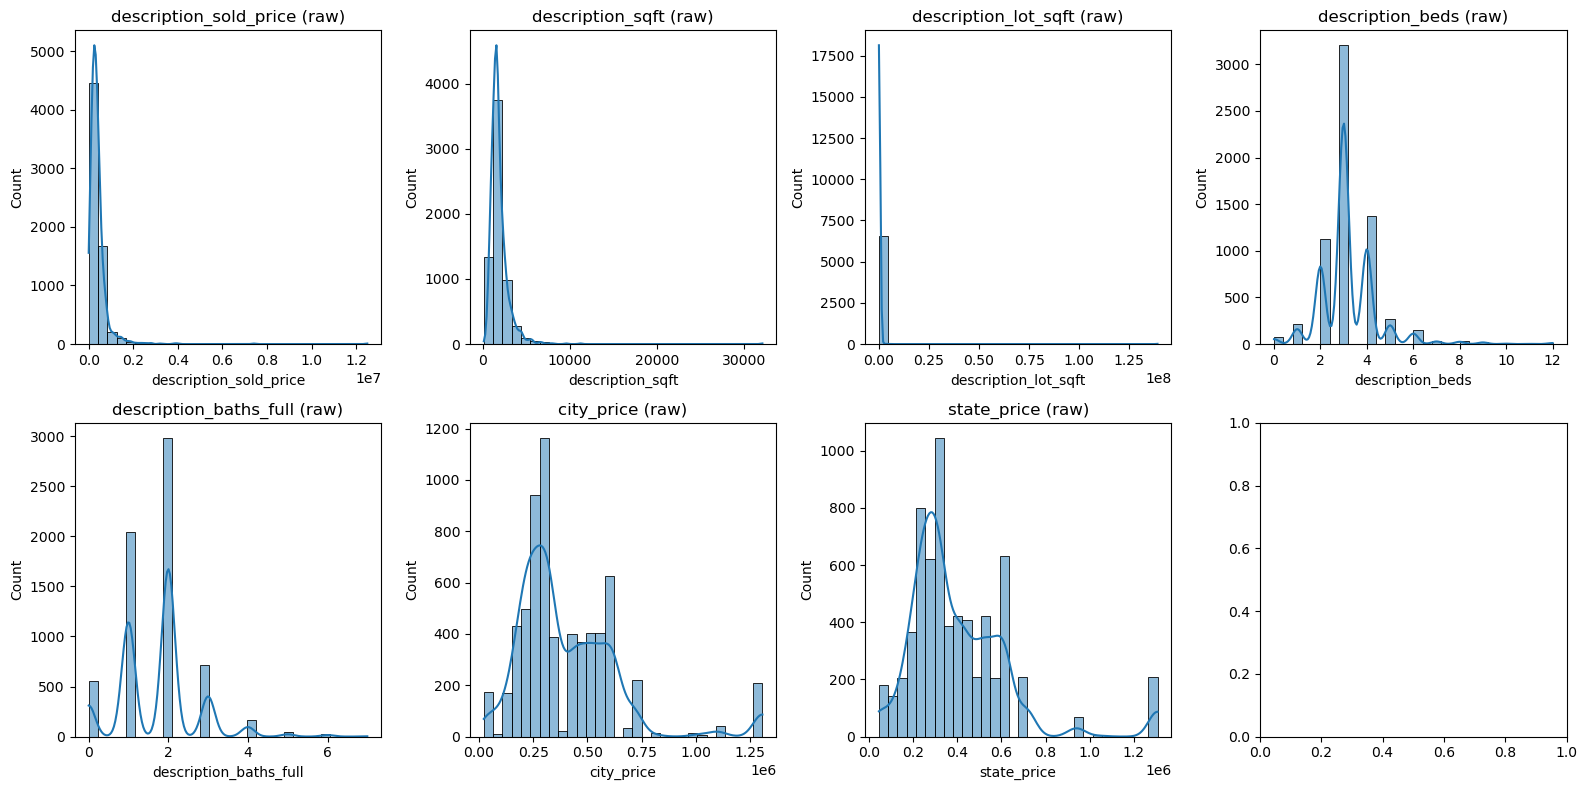

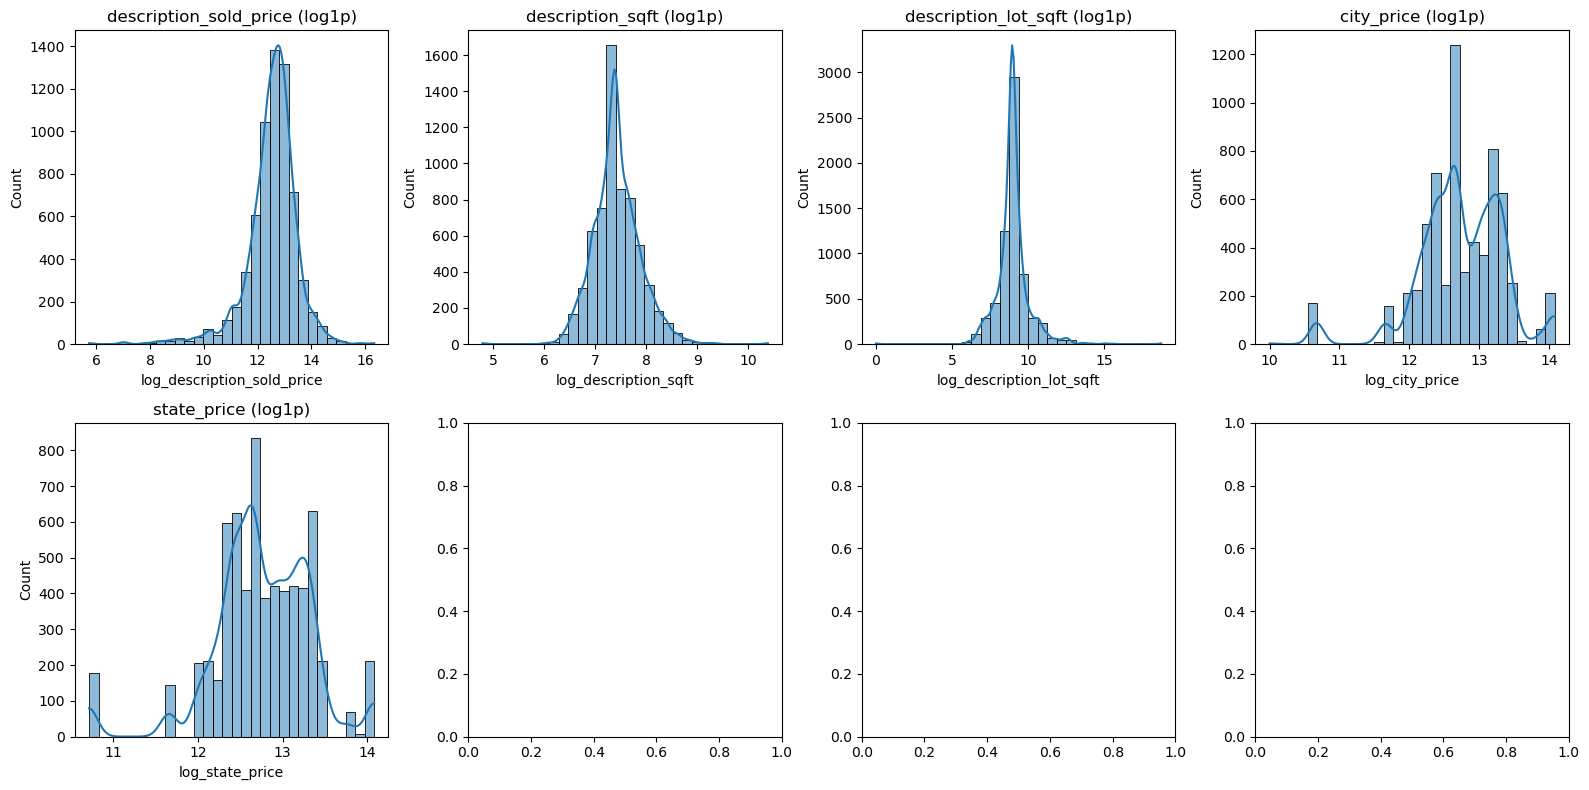

In [51]:
# 1.1 select a few key numeric columns
to_plot = [
    "description_sold_price",
    "description_sqft",
    "description_lot_sqft",
    "description_beds",
    "description_baths_full",
    "city_price",
    "state_price"
]

# 1.2 plot raw histograms
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

for ax, col in zip(axs, to_plot):
    sns.histplot(df[col], bins=30, ax=ax, kde=True)
    ax.set_title(f"{col} (raw)")
    
plt.tight_layout()
plt.show()

# 1.3 log‐transform highly skewed ones
skewed = ["description_sold_price","description_sqft","description_lot_sqft","city_price","state_price"]
for col in skewed:
    df[f"log_{col}"] = np.log1p(df[col])

# 1.4 plot log‐histograms
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

for ax, col in zip(axs, skewed):
    sns.histplot(df[f"log_{col}"], bins=30, ax=ax, kde=True)
    ax.set_title(f"{col} (log1p)")
    
plt.tight_layout()
plt.show()


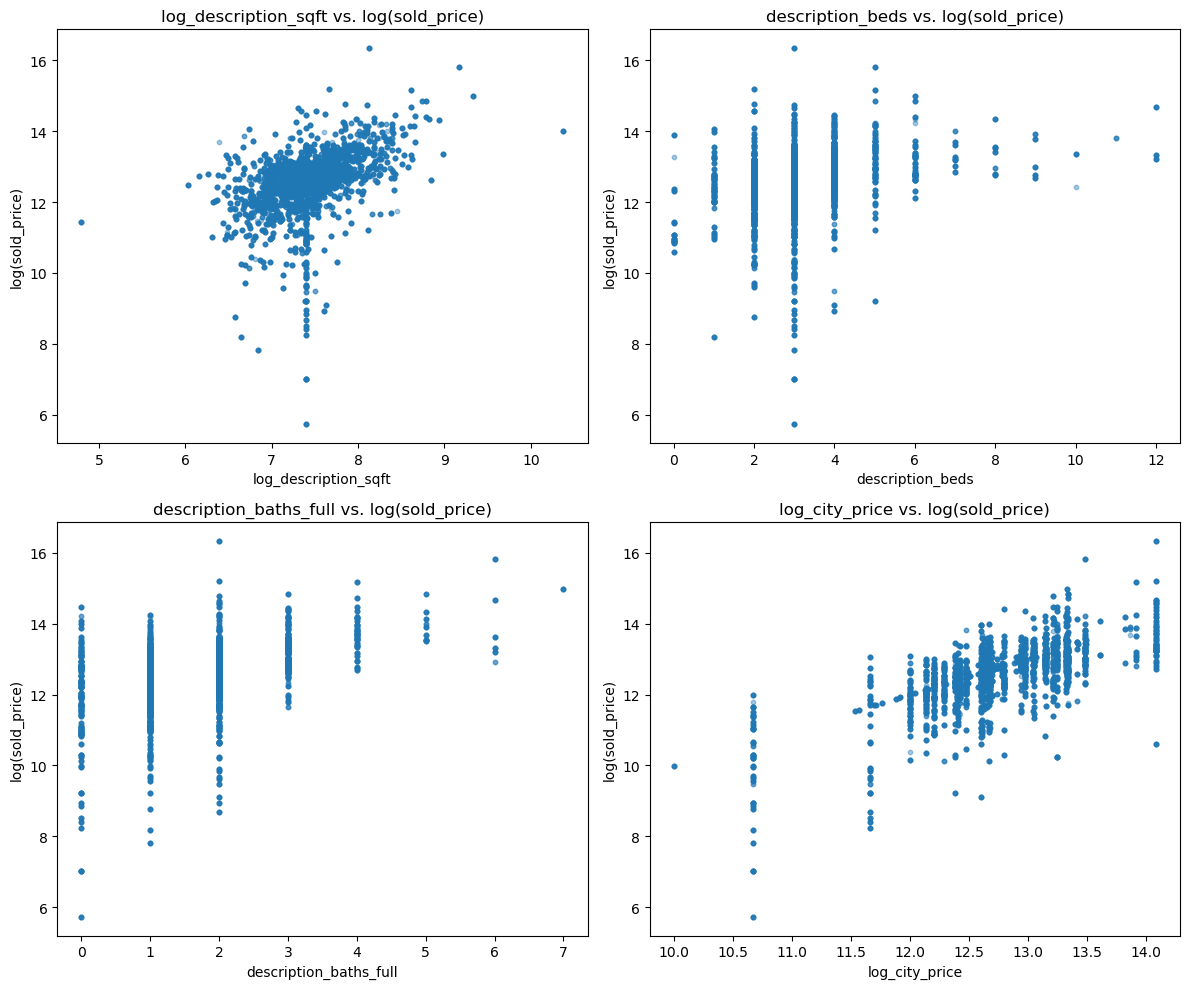

In [52]:
# pick a mix of raw and log‐transformed features
features = [
    "log_description_sqft",
    "description_beds",
    "description_baths_full",
    "log_city_price"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    ax.scatter(df[feat], df["log_description_sold_price"], alpha=0.4, s=10)
    ax.set_xlabel(feat)
    ax.set_ylabel("log(sold_price)")
    ax.set_title(f"{feat} vs. log(sold_price)")

plt.tight_layout()
plt.show()


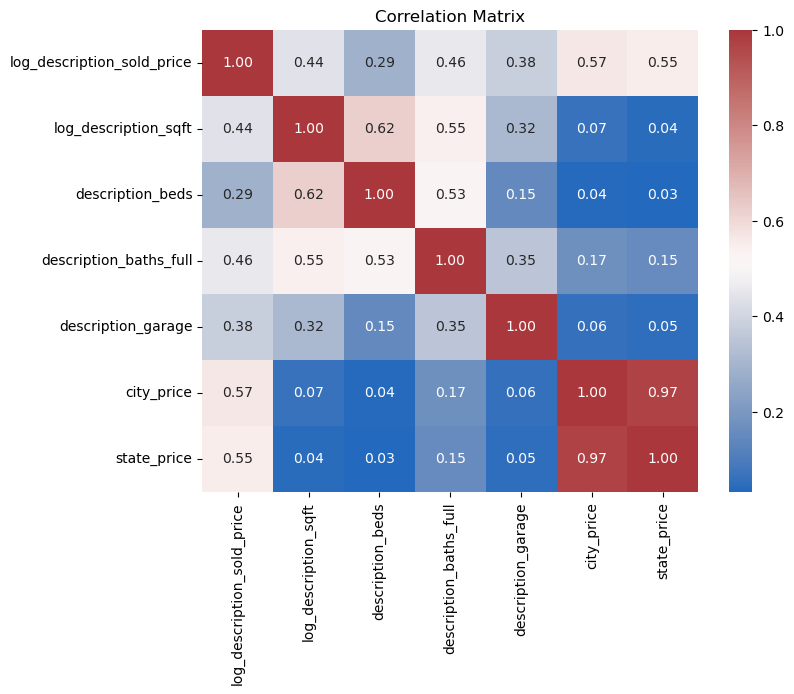

Top absolute correlations (excl. 1.0):
 state_price                 city_price                    0.971813
description_beds            log_description_sqft          0.621894
log_description_sold_price  city_price                    0.565420
state_price                 log_description_sold_price    0.550033
log_description_sqft        description_baths_full        0.546092
description_beds            description_baths_full        0.528204
log_description_sold_price  description_baths_full        0.458703
                            log_description_sqft          0.439224
dtype: float64


In [53]:
# 3.1 choose a moderate set of numeric features
corr_feats = [
    "log_description_sold_price",
    "log_description_sqft",
    "description_beds",
    "description_baths_full",
    "description_garage",
    "city_price",
    "state_price"
]

corr_mat = df[corr_feats].corr()

# 3.2 heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation Matrix")
plt.show()

# 3.3 list top absolute correlations (excluding self)
pairs = (
    corr_mat.abs()
    .unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)
top = pairs[(pairs<1)].head(8)
print("Top absolute correlations (excl. 1.0):\n", top)


Beds vs Baths correlation:
                         description_beds  description_baths_full
description_beds                1.000000                0.528204
description_baths_full          0.528204                1.000000 



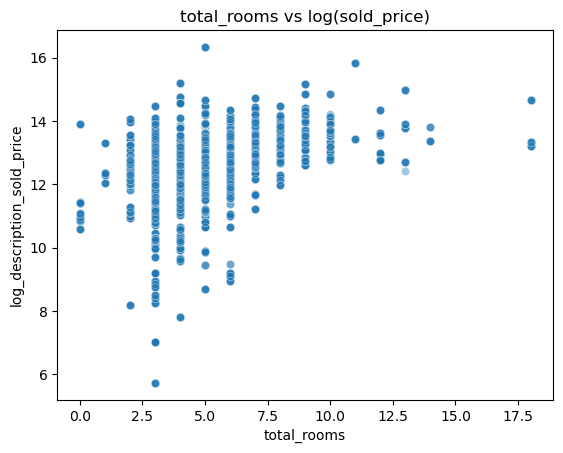

In [54]:
# pick two you suspect are overlapping
print("Beds vs Baths correlation:\n", 
      df[["description_beds","description_baths_full"]].corr(), "\n")

# maybe create a combined feature:
df["total_rooms"] = df["description_beds"] + df["description_baths_full"]
sns.scatterplot(x="total_rooms", y="log_description_sold_price", data=df, alpha=0.4)
plt.title("total_rooms vs log(sold_price)")
plt.show()


## EDA Summary & Action Plan

Before modeling, we cleaned and explored our data to understand its characteristics. We started with raw features like sale price, square footage, lot size, bedroom and bathroom counts, garage size, tag dummies, and city/state names. Early on we noticed:

- **Heavy skew** in price and size, with a few extreme outliers  
- **Redundant information** among bathroom counts and between city vs. state averages  
- **Geographic signal** (city/state) not yet incorporated

**Key improvements made:**

- **Log-transformed** `sold_price`, `sqft`, `lot_sqft`, and `city_price` to reduce skew  
- **Kept only** `city_price` (drops `state_price`) since it explains ~57 % of variance  
- **Merged** `beds` + `baths_full` into a single `total_rooms` feature to reduce collinearity  
- **Pruned** rare tag columns (< 1 % frequency) and extra bath variables

With these changes, our dataset is now leaner and more consistent, and ready for Part 2 (baseline regression and tree-based models using RMSE on the log target).  


## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized